<a href="https://colab.research.google.com/github/abyssyli/Summer2025/blob/main/koffi610.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Using PINNS to solve 1-D Heat Equation**

Suppose we are considering the one-dimensional heat equation:

$$
\frac{\partial u(x, t)}{\partial t} = \alpha \frac{\partial^2 u(x, t)}{\partial x^2}, \quad x \in [0, 1],\ t \in [0, T]
$$

Where:

- $u(x, t)$ is the temperature distribution;
- $\alpha$ is the thermal diffusivity (e.g., $\alpha = 0.01$);
- The initial condition is $u(x, 0) = f(x)$, e.g., $f(x) = \sin(\pi x)$;
- The boundary condition is $u(0, t) = u(1, t) = 0$.


The basic Workflow of Using PINNs to Solve This Type of Equation is:

1. Define a neural network with inputs $x$, $t$, and output $u(x, t)$.

2. Construct a loss function consisting of three components:

   (1). Initial condition loss: $L_{IC}$

   (2). Boundary condition loss: $L_{BC}$

   (3). PDE physics-informed loss  
 (based on automatic differentiation of $\partial u / \partial t$ and $\partial^2 u / \partial x^2$): $L_{PDE}$

3. Train the neural network to minimize the total loss.


The details are listed in the following parts:


**Part 1. Set seeds**

The random seed is set to ensure reproducible results (the initialization parameters and training points are the same for each run)

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Set seeds
torch.manual_seed(0)
np.random.seed(0)

**Part 2. Define the neural network**

Here a three-layer neural network is constructed with a 2D input \\((x, t)\\) and a 1D output (the predicted \\(u(x, t)\\)).

The `Tanh` activation function helps maintain numerical stability (suitable for physical modeling).

The network learns a function that satisfies the PDE and the boundary/initial conditions.

---

**Forward Pass of the PINN Model**

Here we define the forward pass of the neural network. This method will be automatically called when we run `model(x, t)`. Python then returns ``` self.net(torch.cat([x, t], dim=1)) ```

We then concatenate the spatial input `x` and temporal input `t` along the feature dimension (`dim=1`), producing a combined tensor where each row represents one \((x, t)\) pair. This concatenated input is then passed through the neural network `self.net`, which returns the model's prediction \( u(x, t) \).



In [2]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 32), nn.Tanh(),
            nn.Linear(32, 32), nn.Tanh(),
            nn.Linear(32, 1)
        )

    def forward(self, x, t):
        return self.net(torch.cat([x, t], dim=1))


**Part 3. Initialize the network and optimizer**


alpha = 0.01 is the thermal diffusivity constant ($\alpha$) in the heat equation:

$\frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2}$

It determines how quickly heat spreads through the medium.


A larger $\alpha$ means faster heat conduction, while a smaller $\alpha$ results in slower thermal diffusion.

In [3]:
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
alpha = 0.01

**Part 4. Sampling Training points**

The data PINNS needs can be divided into three categories:

**1**. PDE collocation points, which enforce the network to satisfy the differential equation. We have $ N_f = 1000 pieces of (x_f, t_f)$.

---

**Question**: How these points 'force' the network to satisify our PDE?


**Firstly**, recall that for traditional numerical methods to solve PDEs, in classical methods like finite difference or finite element, the PDE is satisfied approximately on a discretized grid using difference formulas. For example, for the 1D heat equation: $$ \frac{\partial u}{\partial t} = \alpha \frac{\partial^2 u}{\partial x^2} $$ we would write: $$ \frac{u(x, t+\Delta t) - u(x, t)}{\Delta t} \approx \alpha \cdot \frac{u(x+\Delta x, t) - 2u(x, t) + u(x-\Delta x, t)}{(\Delta x)^2} $$ This approach requires a mesh and discretization of both time and space.

**However**, for PINNs solve the PDE, it represent the solution $u(x, t)$ as a neural network. Instead of discretizing the PDE, we train the network to minimize the PDE residual at a set of collocation points $(x_f, t_f)$. We want: $$ \left| \frac{\partial u}{\partial t}(x_f, t_f) - \alpha \frac{\partial^2 u}{\partial x^2}(x_f, t_f) \right|^2 \to \min $$



To this end, we want to implemented this in code, and key idea is to use **automatic differentiation** (`autograd`) to compute the derivatives.

Here ```u = model(x_f, t_f) ``` corresponds to the predicted $u(x, t)$.
```u_t = torch.autograd.grad(u, t_f, ...)```
corresponds to $\frac{\partial u}{\partial t}$.
```u_x = torch.autograd.grad(u, x_f, ...) ``` corresponds to∂$\frac{\partial u}{\partial x}$.
``` u_xx = torch.autograd.grad(u_x, x_f, ...)```
 corresponds to$\frac{\partial^2 u}{\partial x^2}$.

Then the PDE loss is computed as: ```python loss_f = torch.mean((u_t - alpha * u_xx) ** 2) ```

This corresponds to the residual: $$ \mathcal{L}_\text{PDE} = \frac{1}{N_f} \sum_{i=1}^{N_f} \left( \frac{\partial u}{\partial t}(x_i, t_i) - \alpha \frac{\partial^2 u}{\partial x^2}(x_i, t_i) \right)^2 $$ which penalizes the network if its output does not satisfy the PDE at those points.

Hence, to use PINNS to solve PDE, we do not provide the network with a target output $u(x,t)$. Instead, we **train it to minimize the PDE residual** at collocation points.

If the residual is not close to zero, the loss is high, and the network updates its parameters to reduce this error. This process forces the network to approximate a function that satisfies the PDE.



---

**2**. Initial condition points $N_i$

$t_i = 0$ which corresponds to the initial time;

$u_i = \sin(\pi x)$ is the true initial temperature profile, i.e., $u(x, 0) = \sin(\pi x)$;

The network learns to make $model(x_i, t_i)$ approximate $u_i$.


---

**3**. Boundary condition points $N_b$

$x = 0$ is the left boundary;

$x = 1$ is the right boundary;

$t_b$ is sampled over the time domain;

The condition is: $$ u(0, t) = 0, \quad u(1, t) = 0 $$.

 The network must output 0 at these boundary points.

In [6]:
# Number of training points
N_f, N_i, N_b = 1000, 100, 100

#PDE collocation points sampled randomly from the interior of the domain (x ∈ [0,1], t ∈ [0,1])
x_f = torch.rand(N_f, 1)     # random spatial points for PDE residual
t_f = torch.rand(N_f, 1)     # random temporal points for PDE residual

# Initial condition points sampled at t = 0
x_i = torch.rand(N_i, 1);    # random spatial positions at initial time
t_i = torch.zeros_like(x_i)  # all time values set to t = 0 (initial time)
u_i = torch.sin(np.pi * x_i) # true initial condition: u(x, 0) = sin(pi * x)

# Boundary condition points sampled at x = 0 and x = 1
t_b = torch.rand(N_b, 1)   # random time values for boundary condition
x_b0 = torch.zeros(N_b, 1) # x = 0 boundary points
x_b1 = torch.ones(N_b, 1)  # x = 1 boundary points

**Part 5. Define PDE loss**

The ```loss_fn()``` function defines the total loss used to train the PINNS. The total loss consists of three parts: the PDE residual term, the initial condition term, and the boundary condition term.

---

**Firstly**, it enables autograd tracking by setting ```requires_grad=True``` for ```x_f``` and ```t_f```, which allows the model to compute derivatives of the network output $u(x, t)$ with respect to both space and time.

The neural network **then** predicts $u(x, t)$ at the collocation points $(x_f, t_f)$, which are randomly sampled from the interior of the domain.

---

Using torch.autograd.grad, the function calculates the necessary partial derivatives: $\frac{\partial u}{\partial t}$, $\frac{\partial u}{\partial x}$, and $\frac{\partial^2 u}{\partial x^2}$.


These derivatives are used to construct the PDE residual.


The total loss consists of three components:

- **PDE loss**:  
  $\left\| \frac{\partial u}{\partial t} - \alpha \frac{\partial^2 u}{\partial x^2} \right\|^2$

- **Initial loss**:  
  $\left\| u(x, 0) - \sin(\pi x) \right\|^2$

- **Boundary loss**:  
  $\left\| u(0, t) \right\|^2 + \left\| u(1, t) \right\|^2$

We use `torch.autograd.grad()` to automatically compute first and second-order derivatives.

---

The term ```loss_f``` represents the mean squared error of the residual
$\frac{\partial u}{\partial t} - \alpha \frac{\partial^2 u}{\partial x^2}$,
forcing the network to satisfy the heat equation across the domain.

The term ```loss_i``` represents that the initial condition at $t = 0$, requiring the network’s output to match the true initial profile $u(x, 0) = \sin(\pi x)$.

The term ```loss_b``` handles the boundary conditions at $x = 0$ and $x = 1$, where the solution must always be zero:
$u(0, t) = u(1, t) = 0$.


**Finally**, the function returns the sum of the three loss components as the total objective.
This guides the network to learn a solution that satisfies the governing PDE, as well as the associated initial and boundary conditions.

In [7]:
# Define total loss: PDE residual + initial condition + boundary condition
def loss_fn():
    # Enable gradient tracking for x_f and t_f to compute derivatives of u(x,t)
    x_f.requires_grad = True
    t_f.requires_grad = True

    # Forward pass: predict u(x,t) at PDE collocation points
    u = model(x_f, t_f)

    # Compute partial derivative ∂u/∂t using autograd
    u_t = torch.autograd.grad(u, t_f, torch.ones_like(u), create_graph=True)[0]

    # Compute partial derivative ∂u/∂x
    u_x = torch.autograd.grad(u, x_f, torch.ones_like(u), create_graph=True)[0]

    # Compute second derivative ∂²u/∂x²
    u_xx = torch.autograd.grad(u_x, x_f, torch.ones_like(u_x), create_graph=True)[0]

    # PDE loss: enforce heat equation ∂u/∂t = α ∂²u/∂x²
    loss_f = torch.mean((u_t - alpha * u_xx)**2)

    # Initial condition loss: enforce u(x,0) = sin(πx)
    loss_i = torch.mean((model(x_i, t_i) - u_i)**2)

    # Boundary condition loss: enforce u(0,t) = u(1,t) = 0
    loss_b = torch.mean(model(x_b0, t_b)**2) + torch.mean(model(x_b1, t_b)**2)

    # Total loss: sum of PDE, initial, and boundary condition losses
    return loss_f + loss_i + loss_b


**Part 6. Training Loop**

In each training iteration, we compute the total loss `total`.

We Use `.backward()` to perform backpropagation and `optimizer.step()` to update the network parameters.


In [13]:
# Train
for epoch in range(2000):
    optimizer.zero_grad()
    loss = loss_fn()
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.5f}")

Epoch 0: loss = 0.73978
Epoch 200: loss = 0.28976
Epoch 400: loss = 0.00857
Epoch 600: loss = 0.00304
Epoch 800: loss = 0.00109
Epoch 1000: loss = 0.00038
Epoch 1200: loss = 0.00018
Epoch 1400: loss = 0.00012
Epoch 1600: loss = 0.00009
Epoch 1800: loss = 0.00007


**Part 7. Construct a 2D $(x, t)$ Grid for Visualization of $u(x, t)$**

To evaluate and visualize the model's prediction over the entire domain, we create a 2D grid of size $100 \times 100$ using `torch.linspace()`.

To be more specific,

`x_test` and `t_test` are linearly spaced points between 0 and 1, each reshaped to column vectors of shape $[100, 1]$.

`torch.meshgrid()` is used to create the full 2D grid $(X, T)$ where each point represents a unique $(x, t)$ pair.

`X` and `T` are flattened into `x_flat` and `t_flat`, which are passed to the trained model for prediction.

This grid allows us to generate the full solution $u(x, t)$ and visualize the model's output over space and time.

In [14]:
# Generate grid prediction
x_test = torch.linspace(0, 1, 100).view(-1, 1)
t_test = torch.linspace(0, 1, 100).view(-1, 1)
X, T = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing="ij")
x_flat = X.reshape(-1, 1) # shape: (10000, 1)
t_flat = T.reshape(-1, 1) # shape: (10000, 1)

**Model Evaluation and Relative $L^2$ Error**

We use the trained model to generate predictions on a full $(x, t)$ grid and compare them to the exact analytical solution of the 1D heat equation. This allows us to quantitatively assess the model’s accuracy.

Here `torch.no_grad()` disables gradient tracking during evaluation to save memory and speed up inference.

`model(x_{\text{flat}}, t_{\text{flat}})` predicts $u_{\text{pred}}(x, t)$ over the entire grid of test points.

---

The **analytical (true) solution** of the heat equation is:
  $$
  u_{\text{true}}(x, t) = e^{-\alpha \pi^2 t} \cdot \sin(\pi x)
  $$

Now both predicted and true values are reshaped into $100 \times 100$ grids to match the original mesh.

---

The **relative $L^2$ error** is computed as:

  $$
  \text{Relative Error} = \frac{ \| u_{\text{pred}} - u_{\text{true}} \|_2 }{ \| u_{\text{true}} \|_2 }
  $$


A small relative error (e.g., less than $10^{-2}$) indicates that the neural network has successfully learned an accurate approximation of the heat equation solution.


In [15]:
with torch.no_grad():
    u_pred = model(x_flat, t_flat).reshape(100, 100)
    u_true = torch.exp(-alpha * np.pi**2 * t_flat) * torch.sin(np.pi * x_flat)
    u_true = u_true.reshape(100, 100)
    rel_error = torch.norm(u_pred - u_true) / torch.norm(u_true)
    print(f"\nRelative L2 error: {rel_error:.2e}")


Relative L2 error: 3.43e-03


**Part 8. Visualization of Results**

1. PINN Prediction ($u_{\text{pred}}$)

This is a contour heatmap of the predicted solution $u_{\text{pred}}(x, t)$ generated by the neural network over the space-time grid.

It shows how the model approximates the temperature distribution.

---

2. Analytical Solution ($u_{\text{true}}$)

This is the ground-truth solution computed from the exact formula:
$$
  u(x, t) = e^{-\alpha \pi^2 t} \cdot \sin(\pi x)
  $$

It serves as a reference to compare the accuracy of the predicted result.

---

3. PDE Residual Histogram

We compute the residual of the PDE at the collocation points:
$$
  \text{Residual} = \frac{\partial u}{\partial t} - \alpha \frac{\partial^2 u}{\partial x^2}
  $$

The histogram shows the distribution of residuals. Ideally, all residuals should be close to 0.

A narrow, sharp peak near 0 indicates that the PINN satisfies the differential equation well.

---

All plots are placed side by side using `plt.subplot(1, 3, *)`, and `plt.tight_layout()`.


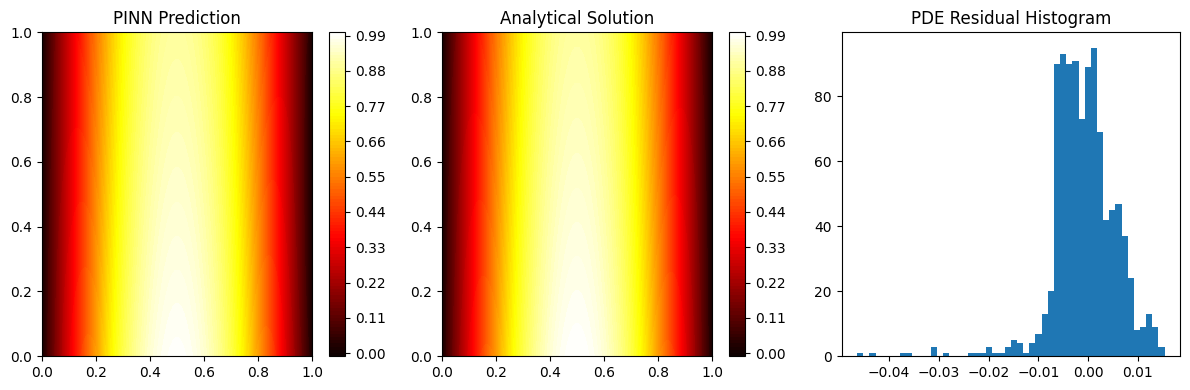

In [18]:
# Plot results
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.contourf(X.numpy(), T.numpy(), u_pred.numpy(), 100, cmap='hot')
plt.title("PINN Prediction"); plt.colorbar()

plt.subplot(1, 3, 2)
plt.contourf(X.numpy(), T.numpy(), u_true.numpy(), 100, cmap='hot')
plt.title("Analytical Solution"); plt.colorbar()

# Residual histogram
x_f.requires_grad = True; t_f.requires_grad = True
u = model(x_f, t_f)
u_t = torch.autograd.grad(u, t_f, torch.ones_like(u), create_graph=True)[0]
u_x = torch.autograd.grad(u, x_f, torch.ones_like(u), create_graph=True)[0]
u_xx = torch.autograd.grad(u_x, x_f, torch.ones_like(u_x), create_graph=True)[0]
residual = (u_t - alpha * u_xx).detach().numpy()

plt.subplot(1, 3, 3)
plt.hist(residual, bins=50)
plt.title("PDE Residual Histogram")
plt.tight_layout()
plt.show()